### Классификация изображений с использованием PyTorch

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

###  Подготовка и изучение данных

In [ ]:
dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tatyanastrizhakova
Your Kaggle Key: ··········


100%|██████████| 346M/346M [00:01<00:00, 187MB/s]


In [ ]:
data_dir = './intel-image-classification'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/seg_train/seg_train')
print(classes)

['seg_pred', 'seg_train', 'seg_test']
['forest', 'glacier', 'mountain', 'street', 'buildings', 'sea']


In [ ]:
# Преобразование данных
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomHorizontalFlip(), 
                        tt.RandomRotation(30),
                        #tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                        tt.Resize((32, 32)),
                        tt.ToTensor(), 
                        tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
data_ds = ImageFolder(data_dir+'/seg_train/seg_train', train_tfms)
test_ds = ImageFolder(data_dir+'/seg_test/seg_test', valid_tfms)
classes = data_ds.classes

In [ ]:
len(data_ds)

14034

Classes: 6 - ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] 
Examples: 14034
Counts: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


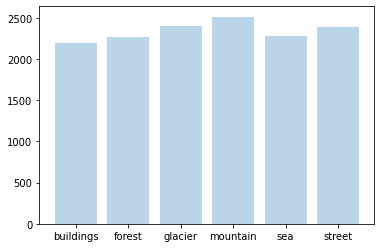

In [ ]:
def describe_dataset(data):
    classes_count = { c:0 for c in classes}
    for _,label in data:
        classes_count[classes[label]]+=1

    print(f'Classes: {len(classes)} - {classes} ')
    print(f'Examples: {len(data)}')
    print(f'Counts: {classes_count}')
    plt.bar(classes_count.keys(),classes_count.values(), alpha=0.3 )

    return classes_count

_ = describe_dataset(data_ds)

In [ ]:
from torch.utils.data import random_split

val_size = 4000
train_size = len(data_ds) - val_size
train_ds, valid_ds = random_split(data_ds, [train_size, val_size])
len(train_ds), len(valid_ds)

(10034, 4000)

In [ ]:
print(train_ds[0][0].shape)
train_ds[0]

torch.Size([3, 32, 32])


(tensor([[[-2.4291, -2.4291, -2.4291,  ..., -1.6149, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.3709,  ..., -1.1303, -2.4097, -2.4291],
          [-2.0414, -1.8669, -1.7118,  ..., -1.1109, -2.3321, -2.4291],
          ...,
          [-2.4291, -2.4097, -1.9832,  ..., -1.4792, -1.7312, -1.9251],
          [-2.4291, -2.4291, -2.0026,  ..., -2.3709, -2.4291, -2.4291],
          [-2.4291, -2.4291, -1.9832,  ..., -2.4291, -2.4291, -2.4291]],
 
         [[-2.4183, -2.4183, -2.4183,  ..., -1.7692, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.3789,  ..., -1.5136, -2.3986, -2.4183],
          [-2.1233, -2.0249, -1.9659,  ..., -1.3759, -2.3396, -2.4183],
          ...,
          [-2.4183, -2.3986, -2.1429,  ..., -1.8086, -1.9856, -2.1036],
          [-2.4183, -2.4183, -2.1429,  ..., -2.3789, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.1036,  ..., -2.4183, -2.4183, -2.4183]],
 
         [[-2.2214, -2.2214, -2.2214,  ..., -1.7727, -2.2214, -2.2214],
          [-2.2214, -2.2214,

In [ ]:
def show_example(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  buildings (0)


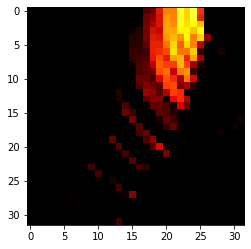

In [ ]:
show_example(*train_ds[0])

In [ ]:
batch_size = 240

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

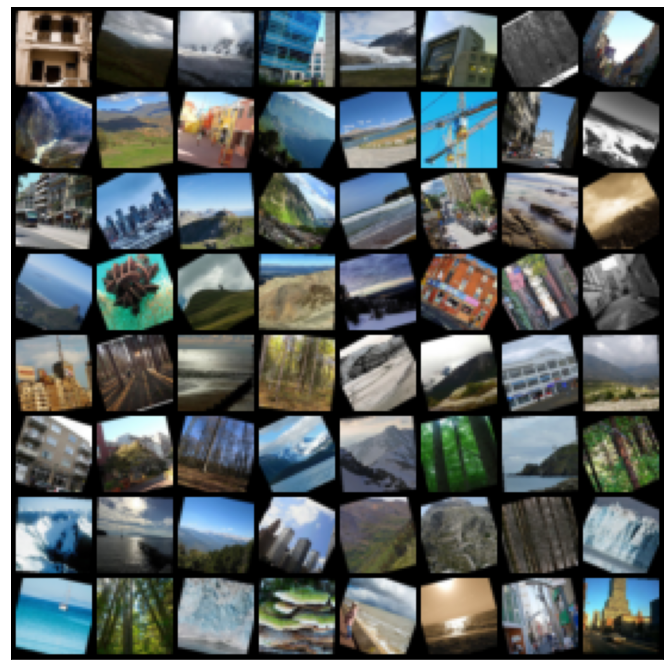

In [ ]:
show_batch(train_dl)

### Использование GPU

Мы будем использовать несколько вспомогательных инструментов для плавного использования графического процессора. Определим вспомогательные функции и вспомогательный класс для перемещения нашей модели и данных на графический процессор по мере необходимости.

In [ ]:
def get_default_device():
    '''Выбирает GPU если он доступен, иначе CPU'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    '''Перемещает тензор на выбранное устройство'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    '''Загрузчик для перемещения данных на устройство'''
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        '''Выдает пакет данных после их перемещения на устройство'''
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        '''Возвращает количество пакетов'''
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### Моделирование, обучение и тестирование

Определим класс ImageClassificationBase, который содержит вспомогательные методы для обучения и проверки на будущих этапах работы с изображениями.

In [ ]:
class ImageClassificationBase(nn.Module):
    def __init__(self, loss_fn=F.cross_entropy):
        super().__init__()
        self.loss_fn = loss_fn

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = self.loss_fn(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = self.loss_fn(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Также определим функции для обучения нашей модели.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs): 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Определение модели

Применим сверточную нейронную сеть, используя nn.Conv2d класс из PyTorch. Мы будет использовать max-pooling слои для постепенного уменьшения высоты и ширины выходного тензора из каждого сверточного слоя, а также nn.Sequential для объединения функций в единую архитектуру.

In [ ]:
class ImagesCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ImagesCnnModel(), device)

history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.16527777910232544, 'val_loss': 2.305715322494507}]

### Обучение модели

In [ ]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                          grad_clip=grad_clip, 
                          weight_decay=weight_decay, 
                          opt_func=opt_func)

Epoch [0], last_lr: 0.00148, train_loss: 1.7943, val_loss: 1.5038, val_acc: 0.3350
Epoch [1], last_lr: 0.00432, train_loss: 1.3105, val_loss: 1.1085, val_acc: 0.5410
Epoch [2], last_lr: 0.00758, train_loss: 1.1698, val_loss: 1.1013, val_acc: 0.5373
Epoch [3], last_lr: 0.00971, train_loss: 1.3924, val_loss: 1.5130, val_acc: 0.4319
Epoch [4], last_lr: 0.00994, train_loss: 1.1824, val_loss: 1.0169, val_acc: 0.5831
Epoch [5], last_lr: 0.00950, train_loss: 1.0512, val_loss: 1.0418, val_acc: 0.5894
Epoch [6], last_lr: 0.00867, train_loss: 0.9776, val_loss: 0.9154, val_acc: 0.6322
Epoch [7], last_lr: 0.00750, train_loss: 0.9279, val_loss: 0.8802, val_acc: 0.6576
Epoch [8], last_lr: 0.00611, train_loss: 0.8939, val_loss: 0.8512, val_acc: 0.6782
Epoch [9], last_lr: 0.00463, train_loss: 0.8347, val_loss: 0.8351, val_acc: 0.6792
Epoch [10], last_lr: 0.00317, train_loss: 0.8014, val_loss: 0.7892, val_acc: 0.7014
Epoch [11], last_lr: 0.00188, train_loss: 0.7264, val_loss: 0.7179, val_acc: 0.7338
Ep

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

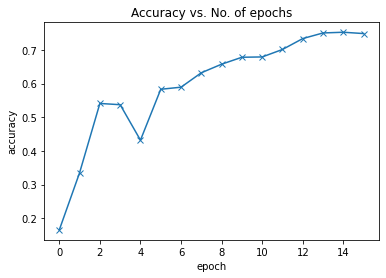

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

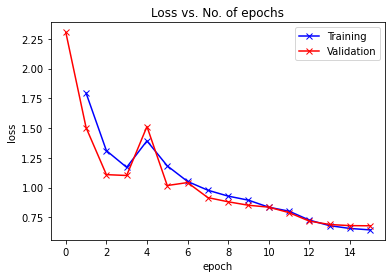

In [ ]:
plot_losses(history)

В ходе обучение подобрали различные параметры для оптимизации процесса. Сверточная нейронная сеть справилась с классификацией изображений, показав точносто около 75%. 